In [1]:
import sys
sys.path.append('../..')
sys.path.append('../../../../transformer_pytorch')
%load_ext autoreload
%autoreload 2

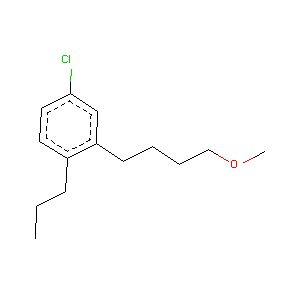

In [14]:

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem.Draw import MolToImage, MolToFile, _moltoSVG, MolsToGridImage

smile1 = 'c1nnn(nnn2)c2c1'
smile7 = 'c1cnnc2n1ncc2'
smile6 = 'c1cncc2n1ccc2'
smile2='OC(=O)O'
smile3 ='c1cccc1'
smile4 = 'C(=C=Nc1c(c2c(OOI)cncn2)nc(Br)c2n1c(I)c(OO)c2)'
smile5 = 'C(OS(=O)(=O))C1SNC(c2c(I)c(NN=O)c(c3cc(F)ccc3C#C)cc2Cl)C(=Nc2nc(S(=O)(=O))c(c3nc(C(c4c(C#N)nnc5n4nnn5)F)nc4n3cnc4c3cnncc3N=C(S)c3c(F)cnc(I)n3)c3n2cnn3)N(SI)NC(F)O1'
smile8 = 'Oc1cc(O)oc1'
smile9 ='Clc1c(c2cnc([C@@][C@@]c3nnc([C@@H]CCS(=O)(=O))c4n3c(c3cnc()c5n3c([C@@]([C@@]([C@@][C@])))cn5)cn4)c3n2nnn3)nnc2n1nnn2'#'[O-]c1nc(O)cc1[C@@][C@]-c1cscc1'
smile9 = 'c5c(c6cnncc6)n(O)nn5'
smile10 ='C/C(O)=C(S)/S'
smile11 ='CC(=O)Nc1cccc(c2cc(NC(=O)Nc3cc(c4cc(F)ccc4)ccc3)ccc2)c1'
kusner1 ='CCCc1ccc(I)cc1C1CCC-c1'
kusner2 ='CC(C)CCCCCc1ccc(Cl)nc1'
kusner3 ='CCCc1ccc(Cl)cc1CCCCOC'
mol = Chem.MolFromSmiles(kusner3)

MolToImage(mol, kekulize=False)

In [15]:
import numpy as np
from generative_playground.rdkit_utils.rdkit_utils import num_atoms, num_aromatic_rings, num_aliphatic_rings, NormalizedScorer
scorer = NormalizedScorer()
[np.sum(x) for x in scorer.get_scores([kusner3])]

[2.353205370805517, 2.7977435486158133]

In [ ]:
MolToFile(mol, 'test.svg', imageType='svg')

In [ ]:
from generative_playground.models.model_settings import get_decoder, get_settings

max_len = 40
settings = get_settings(True, 'new')

# Now let's run a random model with a grammar
model, _ = get_decoder(True,
                    'new',
                    feature_len=settings['feature_len'],
                    max_seq_length=max_len,
                    decoder_type='random',
                   batch_size=9)


In [ ]:
from generative_playground.codec.grammar_codec import GrammarModel
settings = get_settings(True, 'new')
codec = GrammarModel(grammar=settings['grammar'],
                    tokenizer=settings['tokenizer'])
actions = model()[0].detach().cpu().numpy()
#print(actions, settings['feature_len'])
my_smiles = codec.decode_from_actions(actions)
print(my_smiles)

mols = [Chem.MolFromSmiles(my_smile) for my_smile in my_smiles]
print([Descriptors.NumAromaticRings(m) for m in mols if m is not None])
MolsToGridImage(mols, kekulize=False)

In [ ]:
#my_smiles.append'c1ccncn1']

def parse(x):
    # print(x)
    try:
        return next(codec._parser.parse(x))
    except Exception as e:
#         print('fail!')
#         print(e)
        return None
    
tokens = [codec._tokenize(s) for s in my_smiles]
parse_trees = [parse(t) for t in tokens]
print(parse_trees, len(parse_trees))


In [ ]:
fname = '../data/250k_rndm_zinc_drugs_clean.smi'

with open(fname) as f:
    smiles = f.readlines()

for i in range(len(smiles)):
    smiles[i] = smiles[i].strip()


In [ ]:
tokens = [codec._tokenize(s) for s in smiles[:1000]]
parse_trees = [parse(t) for t in tokens]
nice = [ip for ip, p in enumerate(parse_trees) if p is not None]
print(len(nice), nice)

In [ ]:
i = 3

In [ ]:
# C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1
#N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)cc2)cc1
#C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1
#smile = 'Nc2cncc(-c3nncn3C)c2'
smile =  smiles[i]
smile = 'C1CNCCC1'
print(i, smile)
mol = Chem.MolFromSmiles(smile)
parse_tree = parse(codec._tokenize(smile))
if parse_tree is None:
    print('fail!')


MolToImage(mol, kekulize=False)


In [ ]:
# i+=1
# my_smile =smiles[i]
# mols = [Chem.MolFromSmiles(my_smile)]
# print(i, my_smile, [Descriptors.NumAromaticRings(m) for m in mols])
# MolsToGridImage(mols, kekulize=False)


In [ ]:

# from generative_playground.models import grammar_ed_models as grammar_model

# # We load the auto-encoder
# grammar_weights = '../pretrained/my_molecules.mdl'
# grammar_model = grammar_model.ZincGrammarModel(grammar_weights)
# z = grammar_model.encode(['c1nccc2n1ccc2'])
# new_smile = grammar_model.decode(z)